## Reading the data

In [1]:
import pandas as pd
import numpy as np
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import matplotlib.pyplot as plt

df = pd.read_csv("../../corpus_sprint2_balanced_cp.csv", encoding="utf-8")
df = df.dropna()

model = Doc2Vec.load("../../model_doc2vec_balanced_20epochs")

## One hot encoding and concatenating

In [2]:
vectors = model.docvecs.vectors_docs

In [3]:
#print(df)
one_hot = pd.Categorical(df['Product'])
df_dummies = pd.get_dummies(one_hot)

v_df = pd.DataFrame(vectors)
df_concat = pd.concat([v_df, df_dummies], axis = 1)
print(df_concat)

               0         1         2         3         4         5         6  \
0      -0.188312  0.235858 -0.160661 -0.062930  0.088282  0.184802  0.369231   
1      -0.069450  0.123566 -0.331953  0.132706  0.416698 -0.337001  0.119607   
2      -0.145901  0.255647  0.014258 -0.009380  0.239211 -0.127895  0.123045   
3      -0.074536  0.037086 -0.051584 -0.062005  0.204723 -0.108399  0.280387   
4       0.306871 -0.032056 -0.098984 -0.138455  0.197950 -0.033127 -0.198101   
...          ...       ...       ...       ...       ...       ...       ...   
111629 -0.131735  0.009762  0.033046 -0.530487 -0.132169  0.258420 -0.012071   
111630 -0.016358  0.296047  0.117149 -0.307706 -0.198284 -0.304725 -0.305938   
111631 -0.062303  0.288477  0.159682 -0.103658 -0.100076  0.008712 -0.103005   
111632 -0.288595  0.146657 -0.130089  0.103363 -0.111763  0.095894 -0.089777   
111633  0.192410  0.238593 -0.077316  0.058626  0.091606 -0.226398 -0.055350   

               7         8         9  .

## Applying k-means

In [4]:
from sklearn.cluster import KMeans
from sklearn import metrics

### Visual with elbow

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24


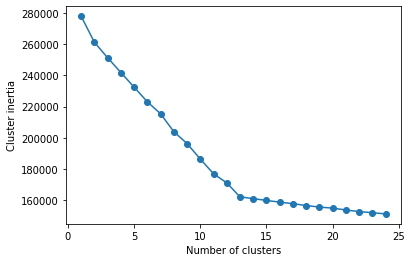

In [5]:
inertia = []
k_min=1
k_max=25
for i in range(k_min, k_max):
    print(i)
    km = KMeans(n_clusters=i,init='k-means++')
    km.fit(df_concat)
    inertia.append(km.inertia_)

plt.plot(range(k_min,k_max), inertia,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Cluster inertia')
plt.show()

### Automatic with silhouette

In [6]:
"""sil_max = -99999
opt_k = 0
k_min=2
k_max=15

for i in range(k_min, k_max):
    print(i)
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_concat)
    
    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    print("Train done")
    silhouette_score = metrics.silhouette_score(df_concat, labels, metric='euclidean')
    print("Silhouette done")
    print(silhouette_score)
    if(sil_max < silhouette_score):
        sil_max = silhouette_score
        opt_k = i


kmeans = KMeans(n_clusters=opt_k)
kmeans.fit(df_concat) 

labels = kmeans.labels_
centroids = kmeans.cluster_centers_
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
 
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(df_concat))
"""

'sil_max = -99999\nopt_k = 0\nk_min=2\nk_max=15\n\nfor i in range(k_min, k_max):\n    print(i)\n    kmeans = KMeans(n_clusters=i)\n    kmeans.fit(df_concat)\n    \n    labels = kmeans.labels_\n    centroids = kmeans.cluster_centers_\n    print("Train done")\n    silhouette_score = metrics.silhouette_score(df_concat, labels, metric=\'euclidean\')\n    print("Silhouette done")\n    print(silhouette_score)\n    if(sil_max < silhouette_score):\n        sil_max = silhouette_score\n        opt_k = i\n\n\nkmeans = KMeans(n_clusters=opt_k)\nkmeans.fit(df_concat) \n\nlabels = kmeans.labels_\ncentroids = kmeans.cluster_centers_\nprint ("Cluster id labels for inputted data")\nprint (labels)\nprint ("Centroids data")\nprint (centroids)\n \nprint ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")\nprint (kmeans.score(df_concat))\n \nsilhouette_score = metrics.silhouette_score(df_concat, labels, metric=\'euclidean\')\

## Plotting the classes

In [8]:
kmeans = KMeans(n_clusters=13)
kmeans.fit(df_concat) 

labels = kmeans.labels_
centroids = kmeans.cluster_centers_

df_clustered = pd.concat([df, pd.DataFrame(labels, columns=["clust"])], axis = 1)
df_clustered = df_clustered.dropna()

                                                  Product  \
0               Payday loan, title loan, or personal loan   
1               Payday loan, title loan, or personal loan   
2                                   Vehicle loan or lease   
3       Money transfer, virtual currency, or money ser...   
4               Payday loan, title loan, or personal loan   
...                                                   ...   
111629                            Bank account or service   
111630                            Bank account or service   
111631                            Bank account or service   
111632                            Bank account or service   
111633                            Bank account or service   

                             Consumer complaint narrative  clust  
0       they would not let me pay my loan off 2 days b...     10  
1       service finance are liars and are charging me ...     10  
2       on xx/xx/ i signed a car loan agreement to fin...     12  

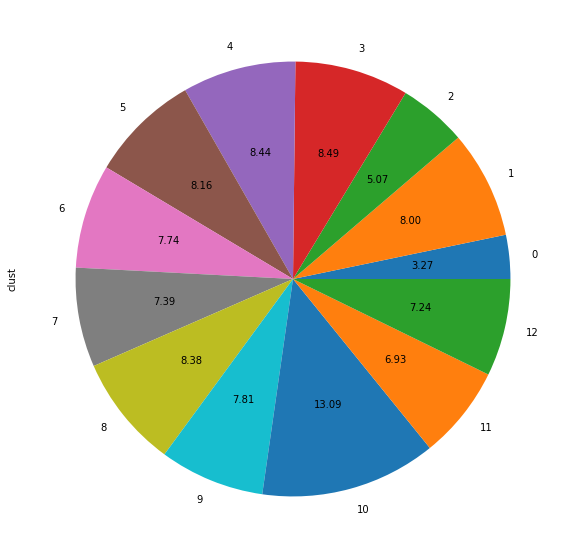

In [9]:
print(df_clustered)

df_clustered.groupby("clust")["clust"].count().plot(kind = "pie", autopct='%.2f', figsize = (10, 10))